<a href="https://colab.research.google.com/github/alvaro-barrera/phishing-detection-url/blob/main/project_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#CONEXIÓN A DRIVE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#INGRESANDO A CARPETA CONTENEDORA DE ARCHIVOS EN DRIVE "ml_database"
%cd '/content/drive/My Drive/Colab Notebooks/db'

/content/drive/My Drive/Colab Notebooks/db


In [4]:
#IMPORTACIÓN DE LIBRERÍAS
import pandas as pd #IMPORTACIÓN DE LIBRERIA - PANDAS
import numpy as np
import seaborn as sn #IMPORTACIÓN DE LIBRERIA - SEABORN
import matplotlib.pyplot as plt #IMPORTACIÓN DE LIBRERIA - MATPLOT
%matplotlib inline
#IMPORTACIÓN DE LIBRERÍA SKLEARN
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler #POR DEFECTO USA VALORES ENTRE 0-1

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from urllib.parse import urlparse

import warnings
warnings.filterwarnings('ignore')


# Conjuntos de datos para la detección de sitios web de phishing


## Breve descripción del conjunto de datos:

> Número total de instancias: 58,645

> Número de instancias de sitios web legítimos (etiquetadas como 0): 27.998

> Número de instancias de sitios web de phishing (etiquetadas como 1): 30,647

In [5]:
#CARGA DE ARCHIVO .CSV 
dataset_complete = pd.read_csv('dataset_full.csv',
                      sep=',', #DEFINIENDO SEPARADOR ',' PROPIO DE .CSV
                      encoding='utf-8', #CODIFICACIÓN UTF-8
                      na_values=' ')

In [6]:
dataset_corr_matrix = dataset_complete.corr(method='pearson') # Matriz de correlación
dataset_corr_matrix

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,qty_tld_url,length_url,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_slash_domain,qty_questionmark_domain,qty_equal_domain,qty_at_domain,qty_and_domain,qty_exclamation_domain,qty_space_domain,qty_tilde_domain,qty_comma_domain,qty_plus_domain,qty_asterisk_domain,qty_hashtag_domain,qty_dollar_domain,qty_percent_domain,qty_vowels_domain,domain_length,domain_in_ip,server_client_domain,...,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length,qty_dot_params,qty_hyphen_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_equal_params,qty_at_params,qty_and_params,qty_exclamation_params,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,qty_percent_params,params_length,tld_present_params,qty_params,email_in_url,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
qty_dot_url,1.000000,0.109737,0.127851,0.246201,0.409549,0.498531,0.169224,0.550918,0.004187,-0.000405,0.027610,0.041252,0.020476,-0.001874,0.001538,0.011338,0.057219,0.404080,0.455914,0.478179,0.038589,-0.001359,NaN,NaN,NaN,0.002198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.138830,0.260156,0.060758,0.018365,...,0.156877,0.156877,0.053408,0.115402,0.709904,0.241199,0.246730,0.304257,0.451345,0.489111,0.411533,0.572987,0.362154,0.364148,0.365060,0.359302,0.355245,0.364296,0.364846,0.365400,0.178111,0.398081,0.422482,0.415170,0.334367,0.003435,-0.009923,0.008808,-0.084548,-0.072755,-0.054120,-0.014089,-0.049845,0.012300,-0.065105,-0.051842,-0.004035,-0.002490,-0.059222,0.171128
qty_hyphen_url,0.109737,1.000000,0.213589,0.304762,0.061247,0.175158,0.041982,0.127984,0.018253,0.018090,0.008251,0.027578,0.010976,0.002567,0.003793,0.013821,0.032065,0.141316,0.401242,-0.024637,0.394951,-0.006857,NaN,NaN,NaN,-0.000987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.093941,0.114223,-0.007436,0.024814,...,0.232658,0.232658,0.081826,0.281972,0.111439,0.456350,0.226894,0.165135,0.168766,0.181646,0.158615,0.154483,0.171575,0.172413,0.171642,0.169433,0.166841,0.172075,0.171298,0.173854,0.092654,0.232307,0.169338,0.197019,0.070524,-0.007577,-0.002388,0.004138,-0.106617,-0.023593,0.029222,0.032991,-0.027048,-0.031027,0.009113,-0.001930,-0.002939,0.006875,-0.010346,0.200382
qty_underline_url,0.127851,0.213589,1.000000,0.246653,0.067009,0.334635,0.056885,0.256192,0.062300,-0.000767,0.040705,0.030282,0.027352,0.015022,0.007476,0.018034,0.086772,0.141620,0.425378,-0.038401,0.045007,0.047863,NaN,NaN,NaN,0.004525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.024149,0.005514,0.003646,0.011161,...,0.184300,0.184300,0.105037,0.252375,0.168244,0.368291,0.741784,0.258239,0.287138,0.353785,0.277094,0.307485,0.320710,0.310356,0.311019,0.303455,0.305843,0.310717,0.310759,0.310991,0.162469,0.361216,0.280543,0.384921,0.083349,-0.004216,0.009043,0.023017,-0.090126,-0.040847,0.004625,0.023962,-0.007595,-0.027089,0.012809,-0.013864,-0.001823,0.003421,-0.012158,0.191151
qty_slash_url,0.246201,0.304762,0.246653,1.000000,0.182759,0.287043,0.102281,0.202511,0.025946,0.015055,0.071848,0.074634,0.024888,0.006965,0.003122,0.022615,0.043673,0.258868,0.569566,-0.203617,0.044168,-0.011382,NaN,NaN,NaN,-0.000500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.061682,-0.033078,0.042247,0.001296,...,0.727309,0.727309,0.263089,0.260026,0.273845,0.244583,0.261506,0.376610,0.366298,0.304786,0.349661,0.259352,0.358095,0.360644,0.361230,0.360616,0.350443,0.360756,0.361378,0.361111,0.132773,0.250221,0.359754,0.308423,0.192707,0.031044,0.000019,0.054107,-0.293195,-0.091701,-0.046034,-0.032416,-0.045904,-0.0219

In [7]:
def tidy_corr_matrix(corr_mat):
  '''
  Función para convertir una matriz de correlación de pandas en formato tidy.
  '''
  corr_mat = corr_mat.stack().reset_index()
  corr_mat.columns = ['variable_1','variable_2','r']
  corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
  corr_mat['abs_r'] = np.abs(corr_mat['r'])
  corr_mat = corr_mat.sort_values('abs_r', ascending=False)
  
  return(corr_mat)

matrix = tidy_corr_matrix(dataset_corr_matrix)

In [8]:
matrix_target_order = matrix[matrix['variable_1'] == 'phishing'].sort_values('abs_r',ascending=False)
matrix_target_order
data_sign =matrix_target_order[matrix_target_order['r'] > 0.5]
sign_columns = data_sign['variable_2'].values.tolist()
sign_columns.append('phishing')
dataset = dataset_complete[dataset_complete.columns[dataset_complete.columns.isin(sign_columns)]]

In [9]:
columns_in_dataset = dataset.columns
dataset.columns

Index(['qty_slash_url', 'qty_dot_directory', 'qty_underline_directory',
       'qty_slash_directory', 'qty_questionmark_directory',
       'qty_equal_directory', 'qty_at_directory', 'qty_and_directory',
       'qty_exclamation_directory', 'qty_space_directory',
       'qty_tilde_directory', 'qty_comma_directory', 'qty_plus_directory',
       'qty_asterisk_directory', 'qty_hashtag_directory',
       'qty_dollar_directory', 'directory_length', 'qty_dot_file',
       'qty_underline_file', 'qty_slash_file', 'qty_questionmark_file',
       'qty_equal_file', 'qty_at_file', 'qty_and_file', 'qty_exclamation_file',
       'qty_space_file', 'qty_tilde_file', 'qty_comma_file', 'qty_plus_file',
       'qty_asterisk_file', 'qty_hashtag_file', 'qty_dollar_file', 'phishing'],
      dtype='object')

In [10]:
dataset.corr(method='pearson')

,qty_slash_url,qty_dot_directory,qty_underline_directory,qty_slash_directory,qty_questionmark_directory,qty_equal_directory,qty_at_directory,qty_and_directory,qty_exclamation_directory,qty_space_directory,qty_tilde_directory,qty_comma_directory,qty_plus_directory,qty_asterisk_directory,qty_hashtag_directory,qty_dollar_directory,directory_length,qty_dot_file,qty_underline_file,qty_slash_file,qty_questionmark_file,qty_equal_file,qty_at_file,qty_and_file,qty_exclamation_file,qty_space_file,qty_tilde_file,qty_comma_file,qty_plus_file,qty_asterisk_file,qty_hashtag_file,qty_dollar_file,phishing
qty_slash_url,1.000000,0.704592,0.661652,0.963604,0.727309,0.729248,0.662482,0.683219,0.721213,0.721502,0.724803,0.726890,0.717210,0.630332,0.727309,0.715229,0.729849,0.713673,0.631291,0.727309,0.727309,0.725091,0.726671,0.726532,0.724946,0.724090,0.727046,0.726701,0.719101,0.664993,0.727309,0.727309,0.699061
qty_dot_directory,0.704592,1.000000,0.691179,0.771962,0.808033,0.794859,0.735835,0.760098,0.801986,0.801492,0.801924,0.809101,0.795891,0.700579,0.808033,0.794368,0.590685,0.915290,0.712600,0.808033,0.808033,0.804961,0.807901,0.807958,0.805908,0.804305,0.807265,0.808506,0.798261,0.739733,0.808033,0.808033,0.690271
qty_underline_directory,0.661652,0.691179,1.000000,0.733952,0.822048,0.811361,0.749549,0.771059,0.817706,0.814608,0.816965,0.820475,0.810166,0.717946,0.822048,0.809331,0.586755,0.745921,0.934768,0.822048,0.822048,0.819746,0.821519,0.819786,0.820735,0.818192,0.821363,0.820543,0.811486,0.754060,0.822048,0.822048,0.623106
qty_slash_directory,0.963604,0.771962,0.733952,1.000000,0.831004,0.828270,0.756946,0.780077,0.824404,0.824260,0.826584,0.829961,0.819212,0.720839,0.831004,0.817335,0.734119,0.795697,0.721614,0.831004,0.831004,0.827951,0.830263,0.829791,0.828551,0.827329,0.830533,0.829869,0.821408,0.760359,0.831004,0.831004,0.746454
qty_questionmark_directory,0.727309,0.808033,0.822048,0.831004,1.000000,0.978538,0.910402,0.935543,0.992881,0.991259,0.988240,0.996516,0.984589,0.868843,1.000000,0.983640,0.523267,0.884677,0.869268,1.000000,1.000000,0.995050,0.999367,0.996957,0.997620,0.995459,0.998734,0.996894,0.987449,0.916741,1.000000,1.000000,0.745644
qty_equal_directory,0.729248,0.794859,0.811361,0.828270,0.978538,1.000000,0.890827,0.921349,0.971513,0.969935,0.967647,0.975214,0.964077,0.850031,0.978538,0.962447,0.542041,0.864852,0.851565,0.978538,0.978538,0.984501,0.977899,0.977684,0.976187,0.974067,0.977411,0.975593,0.966553,0.897038,0.978538,0.978538,0.737922
qty_at_directory,0.662482,0.735835,0.749549,0.756946,0.910402,0.890827,1.000000,0.962974,0.913856,0.902423,0.901504,0.907211,0.897995,0.880523,0.910402,0.943524,0.513597,0.803916,0.790900,0.910402,0.910402,0.905852,0.910964,0.907757,0.908248,0.906257,0.909242,0.907559,0.898955,0.834799,0.910402,0.910402,0.682272
qty_and_directory,0.683219,0.760098,0.771059,0.780077,0.935543,0.921349,0.962974,1.000000,0.939760,0.927337,0.927027,0.932258,0.923647,0.910529,0.935543,0.973366,0.527801,0.827431,0.812901,0.935543,0.935543,0.932936,0.935108,0.938492,0.933279,0.931279,0.934348,0.932616,0.924395,0.857688,0.935543,0.935543,0.702265
qty_exclamation_directory,0.721213,0.801986,0.817706,0.824404,0.992881,0.971513,0.913856,0.939760,1.000000,0.984192,0.983320,0.989502,0.979021,0.873831,0.992881,0.982386,0.523048,0.877887,0.863938,0.992881,0.992881,0.987988,0.992294,0.989841,0.995328,0.988367,0.991800,0.989790,0.980409,0.911431,0.992881,0.992881,0.742187
qty_space_directory,0.721502,0.801492,0.814608,0.824260,0.991259,0.969935,0.902423,0.927337,0.984192,1.000000,0.979581,0.988202,0.975976,0.861226,0.991259,0.975033,0.520414,0.876441,0.861529,0.991259,0.991259,0.986341,0.990629,0.988233,0.988893,0.995772,0.990002,0.988578,0.978813,0.908721,0.991259,0.991259,0.740026


In [11]:
dataset.groupby('phishing').size()

phishing
0    58000
1    30647
dtype: int64

In [12]:
dataset.describe()

,qty_slash_url,qty_dot_directory,qty_underline_directory,qty_slash_directory,qty_questionmark_directory,qty_equal_directory,qty_at_directory,qty_and_directory,qty_exclamation_directory,qty_space_directory,qty_tilde_directory,qty_comma_directory,qty_plus_directory,qty_asterisk_directory,qty_hashtag_directory,qty_dollar_directory,directory_length,qty_dot_file,qty_underline_file,qty_slash_file,qty_questionmark_file,qty_equal_file,qty_at_file,qty_and_file,qty_exclamation_file,qty_space_file,qty_tilde_file,qty_comma_file,qty_plus_file,qty_asterisk_file,qty_hashtag_file,qty_dollar_file,phishing
count,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000
mean,1.281781,-0.323666,-0.477997,0.713685,-0.535935,-0.528343,-0.532550,-0.531422,-0.534310,-0.535145,-0.532765,-0.535224,-0.534863,-0.532235,-0.535935,-0.534626,10.857694,-0.368710,-0.510756,-0.535935,-0.535935,-0.534288,-0.535641,-0.534513,-0.534897,-0.535506,-0.535641,-0.535371,-0.535168,-0.534761,-0.535935,-0.535935,0.345720
std,1.893929,0.899499,0.682409,2.216137,0.498710,0.517986,0.551786,0.538253,0.504044,0.503964,0.508092,0.501220,0.507685,0.578570,0.498710,0.508434,24.352634,0.766855,0.604840,0.498710,0.498710,0.502970,0.499341,0.501764,0.501018,0.501447,0.499657,0.500872,0.505883,0.545378,0.498710,0.498710,0.475605
min,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
75%,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,44.000000,19.000000,17.000000,22.000000,0.000000,5.000000,43.000000,26.000000,9.000000,9.000000,5.000000,5.000000,19.000000,60.000000,0.000000,10.000000,1286.000000,12.000000,17.000000,0.000000,0.000000,3.000000,2.000000,3.000000,4.000000,9.000000,4.000000,5.000000,19.000000,60.000000,0.000000,0.000000,1.000000


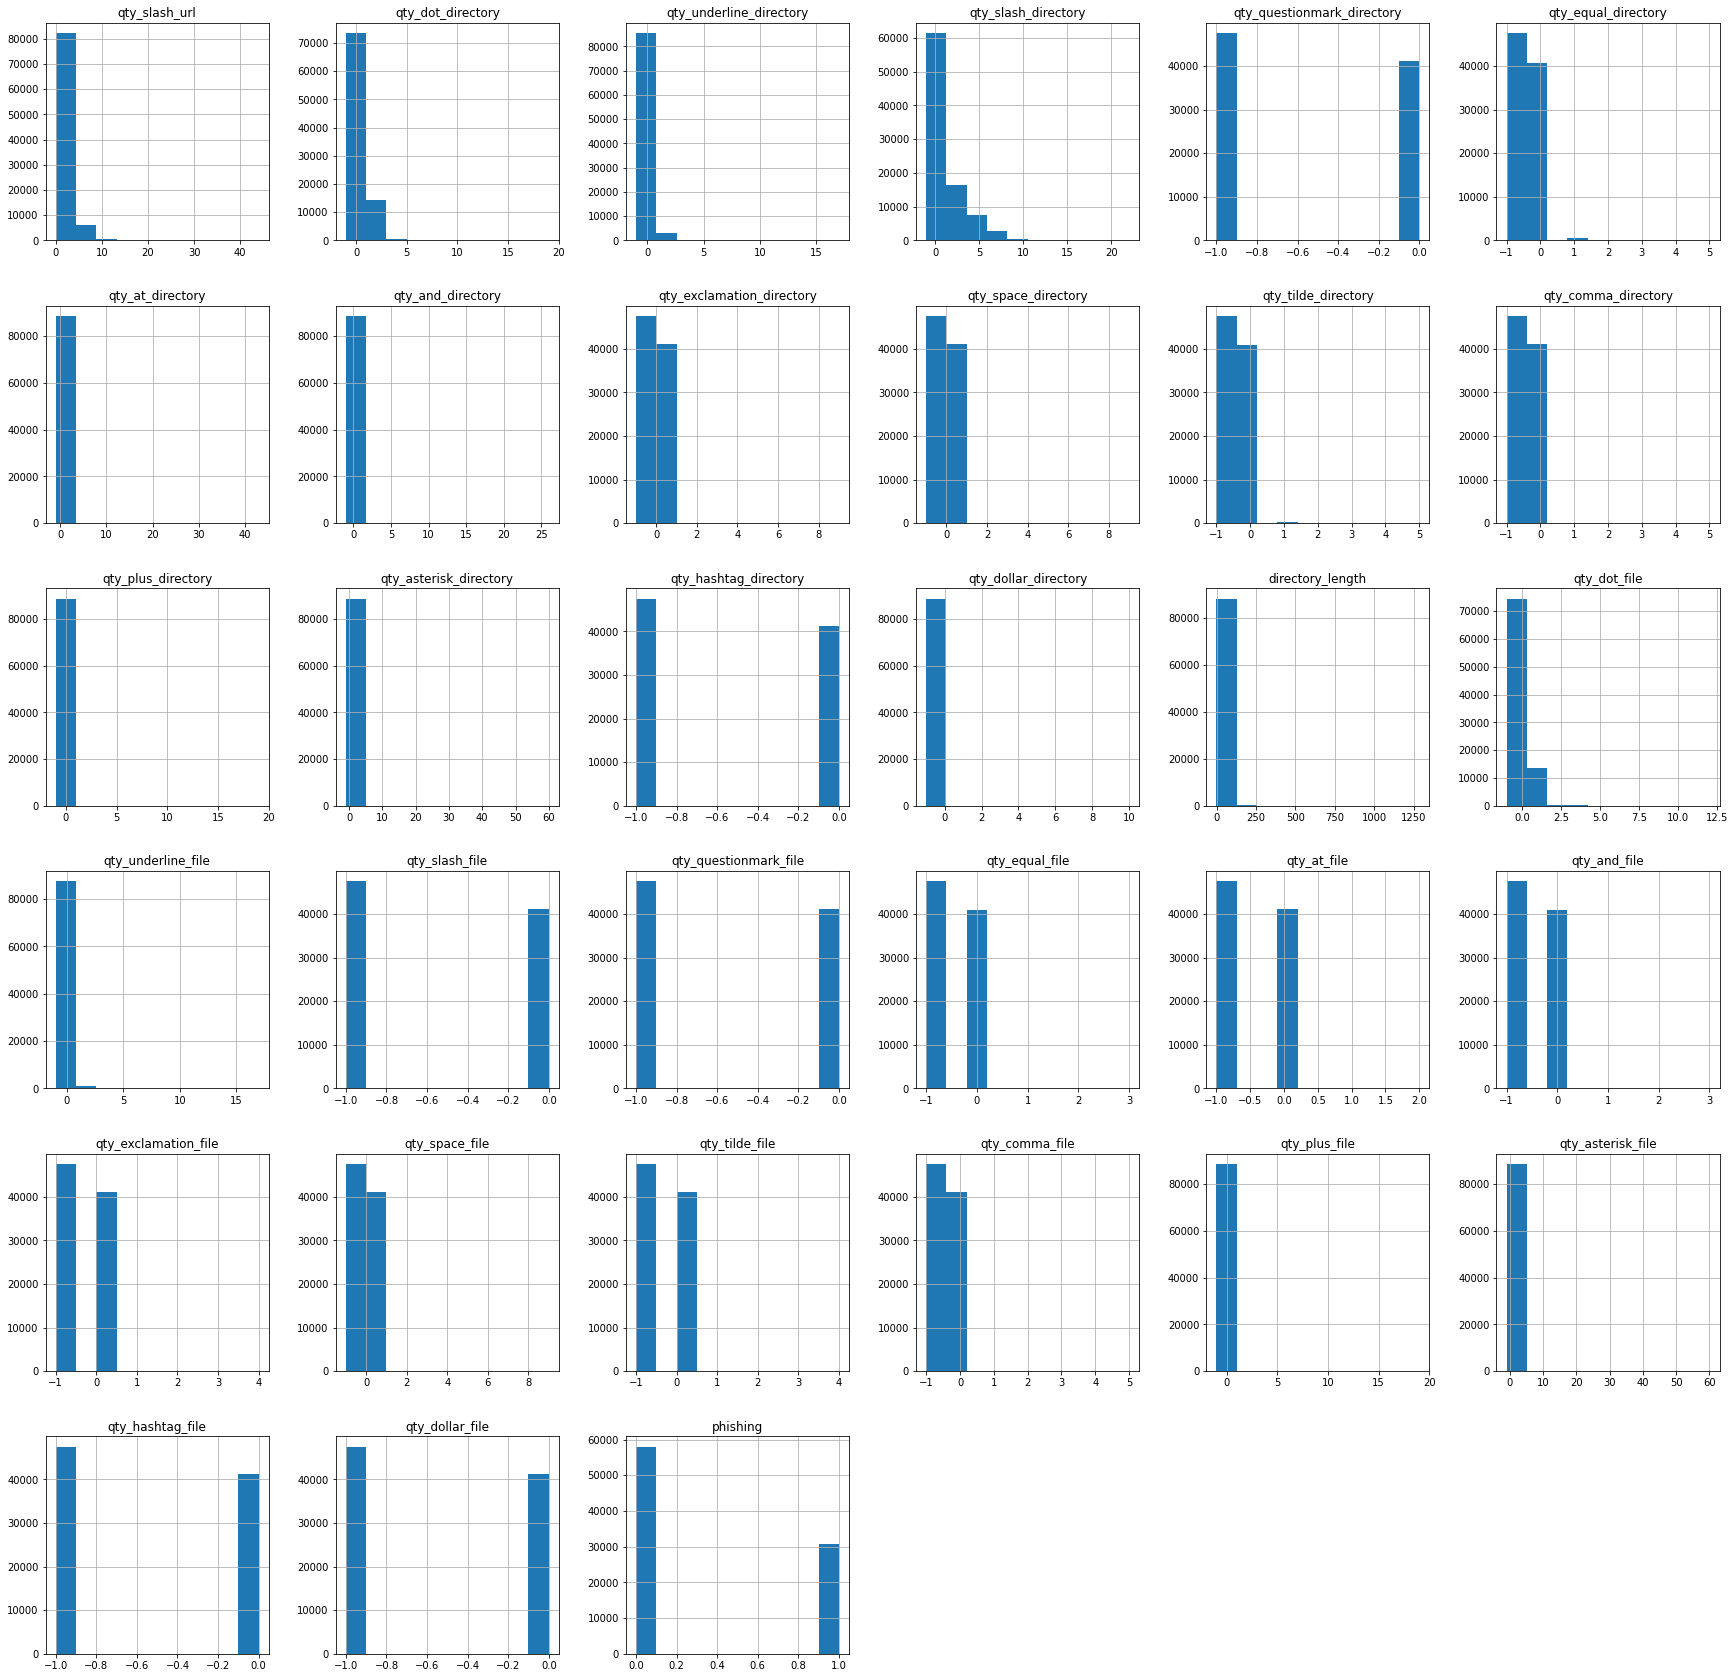

In [13]:
fig = plt.figure(figsize=(30,30))
ax = fig.gca()
dataset.hist(ax=ax)
plt.show()

# VISUALIZACIÓN DE DATOS ESTADÍSTICOS
Variable objetivo: "phishing"

## Descripción de los atributos del dataset

|          Feature           |                   Description                      |
|----------------------------|----------------------------------------------------|
| qty_dot_url                | contador de (.) en URL                                   |
| qty_hyphen_url             | contador de (-) en URL                                   |
| qty_underline_url          | contador de (_) en URL                                   |
| qty_slash_url              | contador de (/) en URL                                   |
| qty_questionmark_url       | contador de (?) en URL                                   |
| qty_equal_url              | contador de (=) en URL                                   |
| qty_at_url                 | contador de (@) en URL                                   |
| qty_and_url                | contador de (&) en URL                                   |
| qty_exclamation_url        | contador de (!) en URL                                   |
| qty_space_url	             | contador de ( ) en URL                                   |
| qty_tilde_url	             | contador de (~) en URL                                   |
| qty_comma_url	             | contador de (,) en URL                                   |
| qty_plus_url	             | contador de (+) en URL                                   |
| qty_asterisk_url	         | contador de (*) en URL                                   |
| qty_hashtag_url	         | contador de (#) en URL                                   |
| qty_dollar_url	         | contador de (símbolo de dólar) en URL                                   |
| qty_percent_url	         | contador de (%) en URL                                   |
| qty_tld_url	             | top-level-domain length                            |
| length_url	             | URL length                                         |
| qty_dot_domain	         | contador de (.) en el dominio                                |
| qty_hyphen_domain	         | contador de (-) en el dominio                                |
| qty_underline_domain       | contador de (_) en el dominio                                |
| qty_slash_domain	         | contador de (/) en el dominio                                |
| qty_questionmark_domain    | contador de (?) en el dominio                                |
| qty_equal_domain           | contador de (=) en el dominio                                |
| qty_at_domain              | contador de (@) en el dominio                                |
| qty_and_domain             | contador de (&) en el dominio                                |
| qty_exclamation_domain     | contador de (!) en el dominio                                |
| qty_space_domain           | contador de ( ) en el dominio                                |
| qty_tilde_domain           | contador de (~) en el dominio                                |
| qty_comma_domain           | contador de (,) en el dominio                                |
| qty_plus_domain            | contador de (+) en el dominio                                |
| qty_asterisk_domain        | contador de (*) en el dominio                                |
| qty_hashtag_domain         | contador de (#) en el dominio                                |
| qty_dollar_domain          | contador de (símbolo de dólar) en el dominio                                |
| qty_percent_domain         | contador de (%) en el dominio                                |
| qty_vowels_domain          | count vowels en el dominio                             |
| domain_length              | domain length                                      |
| domain_in_ip               | Dominio de URL en formato de dirección IP                    |
| server_client_domain       | el dominio contiene las palabras clave "server" o "client"  |
| qty_dot_directory	         | contador de (.) en directorio                             |
| qty_hyphen_directory       | contador de (-) en directorio                             |
| qty_underline_directory    | contador de (_) en directorio                             |
| qty_slash_directory        | contador de (/) en directorio                             |
| qty_questionmark_directory | contador de (?) en directorio                             |
| qty_equal_directory        | contador de (=) en directorio                             |
| qty_at_directory           | contador de (@) en directorio                             |
| qty_and_directory          | contador de (&) en directorio                             |
| qty_exclamation_directory	 | contador de (!) en directorio                             |
| qty_space_directory        | contador de ( ) en directorio                             |
| qty_tilde_directory        | contador de (~) en directorio                             |
| qty_comma_directory        | contador de (,) en directorio                             |
| qty_plus_directory         | contador de (+) en directorio                             |
| qty_asterisk_directory     | contador de (*) en directorio                             |
| qty_hashtag_directory      | contador de (#) en directorio                             |
| qty_dollar_directory       | contador de (símbolo de dólar) en directorio                             |
| qty_percent_directory      | contador de (%) en directorio                             |
| directory_length           | directory length                                   |
| qty_dot_file               | contador de (.) en archivo                                  |
| qty_hyphen_file            | contador de (-) en archivo                                  |
| qty_underline_file         | contador de (_) en archivo                                  |
| qty_slash_file             | contador de (/) en archivo                                  |
| qty_questionmark_file      | contador de (?) en archivo                                  |
| qty_equal_file             | contador de (=) en archivo                                  |
| qty_at_file                | contador de (@) en archivo                                  |
| qty_and_file               | contador de (&) en archivo                                  |
| qty_exclamation_file       | contador de (!) en archivo                                  |
| qty_space_file             | contador de ( ) en archivo                                  |
| qty_tilde_file             | contador de (~) en archivo                                  |
| qty_comma_file             | contador de (,) en archivo                                  |
| qty_plus_file	             | contador de (+) en archivo                                  |
| qty_asterisk_file          | contador de (*) en archivo                                  |
| qty_hashtag_file           | contador de (#) en archivo                                  |
| qty_dollar_file            | contador de (símbolo de dólar) en archivo                                  |
| qty_percent_file           | contador de (%) en archivo                                  |
| file_length                | longitud de archivo                                        |
| qty_dot_params             | contador de (.) en parámetros                            |
| qty_hyphen_params          | contador de (-) en parámetros                            |
| qty_underline_params       | contador de (_) en parámetros                            |
| qty_slash_params           | contador de (/) en parámetros                            |
| qty_questionmark_params    | contador de (?) en parámetros                            |
| qty_equal_params           | contador de (=) en parámetros                            |
| qty_at_params              | contador de (@) en parámetros                            |
| qty_and_params             | contador de (&) en parámetros                            |
| qty_exclamation_params     | contador de (!) en parámetros                            |
| qty_space_params           | contador de ( ) en parámetros                            |
| qty_tilde_params           | contador de (~) en parámetros                            |
| qty_comma_params           | contador de (,) en parámetros                            |
| qty_plus_params            | contador de (+) en parámetros                            |
| qty_asterisk_params        | contador de (*) en parámetros                            |
| qty_hashtag_params         | contador de (#) en parámetros                            |
| qty_dollar_params          | contador de (símbolo de dólar) en parámetros                            |
| qty_percent_params         | contador de (%) en parámetros                            |
| params_length              | longitud de parametros                                  |
| tld_present_params         | presencia de TLD dentro de los argumentos                          |
| qty_params                 | número de parametros                               |
| email_in_url               | email presente en URL                               |
| time_response              | tiempo de busqueda (respuesta) domain (lookup)             |
| domain_spf                 | domonio posee SPF                                     |
| asn_ip                     | Numero AS (o ASN)                                 |
| time_domain_activation     | tiempo (en días) de activacion de dominio                |
| time_domain_expiration     | tiempo (en días) de expiracion de dominio                |
| qty_ip_resolved            | IPs resueltas                            |
| qty_nameservers            | number of resolved name servers (NameServers - NS) |
| qty_mx_servers             | Servidores MX                               |
| ttl_hostname               | time-to-live (TTL) associado con el hostname  |
| tls_ssl_certificate        | Certificado TLS / SSL valido                        |
| qty_redirects              | numero de redirecciones                               |
| url_google_index           | checkeo si URL está indexada en Google                  |
| domain_google_index        | checkeo si dominio está indexado en Google               |
| url_shortened              | checkeo si URL está acortado                          |
                            |

In [14]:
#VISUALIZACIÓN DE DATOS ESTADÍSTICOS DEL DATAFRAME
dataset.describe()

,qty_slash_url,qty_dot_directory,qty_underline_directory,qty_slash_directory,qty_questionmark_directory,qty_equal_directory,qty_at_directory,qty_and_directory,qty_exclamation_directory,qty_space_directory,qty_tilde_directory,qty_comma_directory,qty_plus_directory,qty_asterisk_directory,qty_hashtag_directory,qty_dollar_directory,directory_length,qty_dot_file,qty_underline_file,qty_slash_file,qty_questionmark_file,qty_equal_file,qty_at_file,qty_and_file,qty_exclamation_file,qty_space_file,qty_tilde_file,qty_comma_file,qty_plus_file,qty_asterisk_file,qty_hashtag_file,qty_dollar_file,phishing
count,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000
mean,1.281781,-0.323666,-0.477997,0.713685,-0.535935,-0.528343,-0.532550,-0.531422,-0.534310,-0.535145,-0.532765,-0.535224,-0.534863,-0.532235,-0.535935,-0.534626,10.857694,-0.368710,-0.510756,-0.535935,-0.535935,-0.534288,-0.535641,-0.534513,-0.534897,-0.535506,-0.535641,-0.535371,-0.535168,-0.534761,-0.535935,-0.535935,0.345720
std,1.893929,0.899499,0.682409,2.216137,0.498710,0.517986,0.551786,0.538253,0.504044,0.503964,0.508092,0.501220,0.507685,0.578570,0.498710,0.508434,24.352634,0.766855,0.604840,0.498710,0.498710,0.502970,0.499341,0.501764,0.501018,0.501447,0.499657,0.500872,0.505883,0.545378,0.498710,0.498710,0.475605
min,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
75%,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,44.000000,19.000000,17.000000,22.000000,0.000000,5.000000,43.000000,26.000000,9.000000,9.000000,5.000000,5.000000,19.000000,60.000000,0.000000,10.000000,1286.000000,12.000000,17.000000,0.000000,0.000000,3.000000,2.000000,3.000000,4.000000,9.000000,4.000000,5.000000,19.000000,60.000000,0.000000,0.000000,1.000000


Verficamos la cantidad de datos null por columna.

In [15]:
dataset.count() #Conteo de valores

qty_slash_url                 88647
qty_dot_directory             88647
qty_underline_directory       88647
qty_slash_directory           88647
qty_questionmark_directory    88647
qty_equal_directory           88647
qty_at_directory              88647
qty_and_directory             88647
qty_exclamation_directory     88647
qty_space_directory           88647
qty_tilde_directory           88647
qty_comma_directory           88647
qty_plus_directory            88647
qty_asterisk_directory        88647
qty_hashtag_directory         88647
qty_dollar_directory          88647
directory_length              88647
qty_dot_file                  88647
qty_underline_file            88647
qty_slash_file                88647
qty_questionmark_file         88647
qty_equal_file                88647
qty_at_file                   88647
qty_and_file                  88647
qty_exclamation_file          88647
qty_space_file                88647
qty_tilde_file                88647
qty_comma_file              

In [16]:
  dataset.isnull().sum(axis=0) # Encontrar valores vacíos

qty_slash_url                 0
qty_dot_directory             0
qty_underline_directory       0
qty_slash_directory           0
qty_questionmark_directory    0
qty_equal_directory           0
qty_at_directory              0
qty_and_directory             0
qty_exclamation_directory     0
qty_space_directory           0
qty_tilde_directory           0
qty_comma_directory           0
qty_plus_directory            0
qty_asterisk_directory        0
qty_hashtag_directory         0
qty_dollar_directory          0
directory_length              0
qty_dot_file                  0
qty_underline_file            0
qty_slash_file                0
qty_questionmark_file         0
qty_equal_file                0
qty_at_file                   0
qty_and_file                  0
qty_exclamation_file          0
qty_space_file                0
qty_tilde_file                0
qty_comma_file                0
qty_plus_file                 0
qty_asterisk_file             0
qty_hashtag_file              0
qty_doll

# BALANCEO DE DATOS


In [17]:
target_count = dataset['phishing'].value_counts() #CONTEO DE SUBSCRIPTION_FLAG 0 | 1
count_no_phishing = target_count[0] #CANTIDAD DE "NO PHISHING"
count_phishing = target_count[1] #CANTIDAD DE "PHISHING"

count_phishing,count_no_phishing #VISUALIZANDO CANTIDADES

(30647, 58000)

In [18]:
#SEPARAR EN DOS DATAFRAMES EL DATASET 
dataset_no_phishing = dataset[dataset['phishing'] == 0]
dataset_phishing = dataset[dataset['phishing'] == 1]

*Sampling* aleatorio de los datos, de manera que se tenga la misma cantidad de "phishing" y "no phishing".

In [19]:
dataset_phishing

,qty_slash_url,qty_dot_directory,qty_underline_directory,qty_slash_directory,qty_questionmark_directory,qty_equal_directory,qty_at_directory,qty_and_directory,qty_exclamation_directory,qty_space_directory,qty_tilde_directory,qty_comma_directory,qty_plus_directory,qty_asterisk_directory,qty_hashtag_directory,qty_dollar_directory,directory_length,qty_dot_file,qty_underline_file,qty_slash_file,qty_questionmark_file,qty_equal_file,qty_at_file,qty_and_file,qty_exclamation_file,qty_space_file,qty_tilde_file,qty_comma_file,qty_plus_file,qty_asterisk_file,qty_hashtag_file,qty_dollar_file,phishing
0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,3,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,42,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,5,2,2,5,0,0,0,0,0,0,0,0,0,0,0,0,62,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88635,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
88637,2,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,20,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
88638,4,1,0,4,0,0,0,0,0,0,0,0,0,0,0,0,28,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
88644,5,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,48,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [20]:
#APLICANDO SOBRE-MUESTREO A LOS DATOS
dataset_phishing_over = dataset_no_phishing.sample(count_phishing, replace=True) #NUEVO DATAFRAME DE "PHISHING" BASADO EN UNA MUESTRA DEL DATAFRAME DE "PHISHING" DEL TAMAÑO DE LOS "NO PHISHING"

df_test_over = pd.concat([dataset_phishing, dataset_phishing_over], axis=0) #CONCATENANDO EL DATAFRAME "NO PHISHING" CON EL NUEVO DATAFRAME "PHISHING" DEL SOBREMUESTREO

In [21]:
df_test_over.groupby('phishing').size() #EL TAMAÑO DEL DATASET QUEDA BALANCEADO AL NÚMERO DE "NO PHISHING"

phishing
0    30647
1    30647
dtype: int64

# DATOS DE ENTRENAMIENTO Y TESTING
- Subdivisiones del dataset balanceado: Conjunto de entrenamiento (train) y conjunto de pruebas (test).
- Para entrenar nuestro modelo de Machine Learning y poder saber si está funcionando bien.


In [22]:
from sklearn.model_selection import train_test_split 
columns = dataset.columns.tolist() #COLUMNAS DE DATASET CONVERTIDAS EN UNA LISTA
columns = [x for x in columns if x not in ["phishing"]]  #DEFINIENDO UNA LIST COMPREHENSION

X = df_test_over[columns] #VARIABLES REGRESORAS
Y = pd.DataFrame(df_test_over['phishing'])

X_train, X_test, y_train, y_test = train_test_split(X,Y,
                                                    test_size=.3, #PORCENTAJE PARA TESTING
                                                    random_state=22) #FIJAR SEMILLA PARA OBTENER EL MISMO RESULTADO AL VOLVER A EJECUTAR

In [23]:
X_classification = X
Y_classification = Y

In [24]:
# Logistic Regression Classification 
# X e Y originales: Accuracy 84.44%  (3.18) %

kfold=KFold(n_splits=10)
model=LogisticRegression(solver='lbfgs', max_iter=1000)
results=cross_val_score(model, X_classification, Y_classification, cv=kfold)
print(f"Accuracy {results.mean()*100.0:,.2f}%  ({results.std()*100.0:,.2f}) %")

Accuracy 88.86%  (8.38) %


In [25]:
# Logistic Regression Classification
# X e Y originales: Accuracy 84.44%  (3.18) %
# Test al 20%: Accuracy 87.03%  (0.37) %
# Test al 30%: Accuracy 87.52%  (0.69) %


kfold=KFold(n_splits=10)
model=LogisticRegression(solver='lbfgs', max_iter=1000)
results=cross_val_score(model, X_train, y_train, cv=kfold)
print(f"Accuracy {results.mean()*100.0:,.2f}%  ({results.std()*100.0:,.2f}) %")

Accuracy 88.93%  (0.69) %


In [26]:
# print('Mínimos valores en X_train - Dataframe no normalizado')
# print('*'*55)
# print(X_train.min())
# print('Máximos valores en X_train - Dataframe no normalizado')
# print('*'*55)
# print(X_train.max())

# NORMALIZACIÓN DE DATOS
## ¿POR QUÉ APLICAMOS ESTE ESCALONAMIENTO?
El algoritmo de red neuronal típico requiere datos que en una escala [0, 1]. Una desventaja de la normalización es que pierde cierta información en los datos, especialmente sobre los valores atípicos

In [27]:
scaler_n = MinMaxScaler()

X_train_n = pd.DataFrame(scaler_n.fit_transform(X_train), columns=X_train.columns)
X_test_n = pd.DataFrame(scaler_n.fit_transform(X_train), columns=X_test.columns)
y_train_n = pd.DataFrame(scaler_n.fit_transform(y_train), columns=y_train.columns)
y_test_n = pd.DataFrame(scaler_n.fit_transform(y_train), columns=y_test.columns)

IDENTIFICAR RANGO MÍNIMO Y MÁXIMO EN DATAFRAME'S DE ENTRENAMIENTO - DESPUÉS DE NORMALIZAR
Se comproba el rango en 0-1 para los datos de entrenamiento, se puede decir que, los datos de entrenamiento están balanceados y normalizados.

In [28]:
# print('Mínimos valores en X_train_n - Dataframe normalizado')
# print('*'*55)
# print(X_train_n.min())
# print('Máximos valores en X_train_n - Dataframe normalizado')
# print('*'*55)
# print(X_train_n.max())

In [29]:
# kfold=KFold(n_splits=10)
# model=LogisticRegression(solver='lbfgs', max_iter=1000)
# results=cross_val_score(model, X_train_n, y_train_n, cv=kfold)
# print(f"Accuracy {results.mean()*100.0:,.2f}%  ({results.std()*100.0:,.2f}) %")
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)
clf = LogisticRegression(random_state=0) 
clf.fit(X_train,y_train)
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
print ("train accuracy =", train_score)
print ("test accuracy =", test_score)
# train accuracy = 0.8234048524121744
# test accuracy = 0.8234048524121744

train accuracy = 0.8893369071203823
test accuracy = 0.8908586655065528


# Clasificación por Regresión Logística
Para problemas de clasificación binaria. En este caso, este modelo ayuda a determinar si la entrada pertenece a un sector específico.

In [30]:
# Logistic Regression Classification

kfold=KFold(n_splits=10)
model_LR=LogisticRegression(solver='lbfgs', max_iter=2500)
result_LR=cross_val_score(model_LR, X_train_n, y_train_n, cv=kfold)
print(f"Accuracy {result_LR.mean()*100.0:,.2f}%  ({result_LR.std()*100.0:,.2f}) %")

Accuracy 88.95%  (0.70) %


In [31]:
# LDA Classification

model_LDA=LinearDiscriminantAnalysis()
result_LDA=cross_val_score(model_LDA, X_train_n, y_train_n, cv=kfold)
result_std_LDA = result_LDA.std()
result_mean_LDA = result_LDA.mean()

print(f"Accuracy {result_mean_LDA*100.0:,.2f}%  ({result_std_LDA*100.0:,.2f}) %")

Accuracy 88.94%  (0.71) %


In [32]:
# Gaussian Naive Bayes Classification
# Accuracy 78.68%  (0.50) %

model_GNB=GaussianNB()
result_GNB=cross_val_score(model_GNB, X_train_n, y_train_n, cv=kfold)
result_std_GNB = result_GNB.std()
result_mean_GNB = result_GNB.mean()

print(f"Accuracy {result_std_GNB*100.0:,.2f}%  ({result_mean_GNB*100.0:,.2f}) %")

Accuracy 0.70%  (88.95) %


In [33]:
# KNN Classification

model_KNC=KNeighborsClassifier(n_neighbors=9, algorithm="kd_tree")
result_KNC=cross_val_score(model_KNC, X_train_n, y_train_n, cv=kfold)
result_std_KNC = result_KNC.std()
result_mean_KNC = result_KNC.mean()

print(f"Accuracy {result_mean_KNC*100.0:,.2f}%  ({result_std_KNC*100.0:,.2f}) %")

Accuracy 88.98%  (0.60) %


In [34]:
# CART Classification

model_DTC=DecisionTreeClassifier(criterion="entropy")
result_DTC=cross_val_score(model_DTC, X_train_n, y_train_n, cv=kfold)
result_std_DTC = result_DTC.std()
result_mean_DTC = result_DTC.mean()

print(f"Accuracy {result_mean_DTC*100.0:,.2f}%  ({result_std_DTC*100.0:,.2f}) %")

Accuracy 89.06%  (0.50) %


In [35]:
# SVM Classification

model_SVM=SVC(gamma="auto", C=2.0, kernel="rbf")
result_SVM=cross_val_score(model_SVM, X_train_n, y_train_n, cv=kfold)
result_std_SVM = result_SVM.std()
result_mean_SVM = result_SVM.mean()

print(f"Accuracy {result_mean_SVM*100.0:,.2f}%  ({result_std_SVM*100.0:,.2f}) %")

Accuracy 88.97%  (0.71) %


In [36]:
model_SVM_opt =SVC(gamma="auto", C=10, kernel="rbf")
results_opt=cross_val_score(model_SVM_opt, X_train_n, y_train_n, cv=kfold)
print(f"Accuracy {results_opt.mean()*100.0:,.2f}%  ({results_opt.std()*100.0:,.2f}) %")

Accuracy 88.97%  (0.71) %


In [37]:
model_SVM_opt =SVC(gamma=0.1, C=10, kernel="rbf")
results_opt=cross_val_score(model_SVM_opt, X_train_n, y_train_n, cv=kfold)
print(f"Accuracy {results_opt.mean()*100.0:,.2f}%  ({results_opt.std()*100.0:,.2f}) %")

Accuracy 88.97%  (0.71) %


In [38]:
model_SVM_opt =SVC(gamma=0.1, C=10, kernel="rbf")
results_opt=cross_val_score(model_SVM_opt, X_train_n, y_train_n, cv=kfold)
print(f"Accuracy {results_opt.mean()*100.0:,.2f}%  ({results_opt.std()*100.0:,.2f}) %")

Accuracy 88.97%  (0.71) %


# Comparación de precisión
- Accuracy: RL: 88.95%  (0.70) %
- Accuracy: LDA: 88.94%  (0.71) %
- Accuracy: KNN: 88.98%  (0.60) %
- Accuracy: Naive Bayes: 88.95%  (0.70) %
- Accuracy: CART: 89.06%  (0.51) %
- Accuracy: SVM: 88.97%  (0.71) %

# Predicción real

In [41]:

# def get_file_in_url(url_directory):
#   directory_split = directory.split("/")
#   directory_split_len = len(directory.split("/"))
#   directory_position_last =directory_split_len-1
#   directory_split[directory_position_last]
#   return directory_split[directory_position_last]


# signs = {
#   "qty_slash": "/",
#   "qty_dot": ".",
#   "qty_questionmark": "?",
#   "qty_equal": "=",
#   "qty_at": "@",
#   "qty_and": "&",
#   "qty_exclamation": "!",
#   "qty_space": " ",
#   "qty_tilde": "~",
#   "qty_comma": ",",
#   "qty_plus": "+",
#   "qty_asterisk": "*",
#   "qty_hashtag": "#",
#   "qty_dollar": "$"
# }
# counts = {}
# def get_counts(data):
#   for name, sign in signs.items():
#     counts.update({name: data.count(sign)})
#   return counts



# def process_real_urls(url):
#   # for url in urls:
#   parsed = urlparse(url)
#   url_domain = parsed.netloc
#   url_directory = parsed.path
#   url_file = get_file_in_url(url_directory)
#   #CONTEO
#   url_domain_counts = get_counts(url_domain)
#   url_directory_counts = get_counts(url_directory)
#   url_file_counts = get_counts(url_file)
#   return {"url_domain_counts":url_domain_counts,"url_directory_counts":url_directory_counts,"url_file_counts":url_file_counts}


In [44]:
# url = "https://stackoverflow.com/questions/35616434/how-can-i-get-the-base-of-a-url-in-python"
# # signs = ("/",".","?","=","@","&","!"," ","~",",","+","*","#","$")


# process_real_urls(url)